In [33]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
import pandas as pd
import requests
import os
import numpy as np
from sklearn.neighbors import NearestNeighbors

In [11]:
DATA_PATH = 'data/'

In [12]:
NYC_FILENAME = DATA_PATH + 'NYPD Shooting Incident Data (Historic).zip'

In [13]:
NYC_URL = "https://data.cityofnewyork.us/api/geospatial/833y-fsy8?date=20231228&accessType=DOWNLOAD&method=export&format=Shapefile"

In [65]:
POL_PREC_FILENAME = DATA_PATH +'Police Precincts.zip'

In [58]:
POL_PREC_URL = "https://s-media.nyc.gov/agencies/dcp/assets/files/zip/data-tools/bytes/nypp_23d.zip"

In [18]:
IS_DOWNLOAD_DATASETS = True

# NEW YORK CITY SHOOTING INCIDENTS

# Download New York City Shooting Incident Data file locally or copy directly from link

In [64]:
if IS_DOWNLOAD_DATASETS:
    if not os.path.isfile(NYC_FILENAME):
        response = requests.get(NYC_URL)
        if response.status_code == 200:
            with open(NYC_FILENAME, 'wb') as file:
                file.write(response.content)
            print(f'Plik {NYC_FILENAME} został pomyślnie pobrany i zapisany.')
        else:
            print(f'Nie można pobrać pliku. Kod odpowiedzi HTTP: {response.status_code}')
    else:
        print(f'Plik {NYC_FILENAME} już istnieje na dysku.')
    nyc_df = gpd.read_file(NYC_FILENAME)
else:
    nyc_df = gpd.read_file(NYC_URL)
    print(f"Dane zostały skopiowane z linku {NYC_URL}")

Plik data/NYPD Shooting Incident Data (Historic).zip już istnieje na dysku.


# Print shooting locations

In [43]:
nyc_df.head()

,incident_k,date_occur,time_occur,occur_time,boro,loc_of_occ,precinct,jurisdicti,loc_classf,location_d,...,perp_sex,perp_race,vic_age_gr,vic_sex,vic_race,x_coord_cd,y_coord_cd,latitude,longitude,geometry
0,228798151,2021-05-27,00:00:00.000,21:30:00,QUEENS,None,105.0,0.0,None,None,...,None,None,18-24,M,BLACK,1058925,180924,40.662965,-73.730839,POINT (-73.73084 40.66296)
1,137471050,2014-06-27,00:00:00.000,17:40:00,BRONX,None,40.0,0.0,None,None,...,None,None,18-24,M,BLACK,1005028.000000000000000,234516.000000000000000,40.810352,-73.924942,POINT (-73.92494 40.81035)
2,147998800,2015-11-21,00:00:00.000,03:56:00,QUEENS,None,108.0,0.0,None,None,...,None,None,25-44,M,WHITE,1007667.937500000000000,209836.531250000000000,40.742607,-73.915492,POINT (-73.91549 40.74261)
3,146837977,2015-10-09,00:00:00.000,18:30:00,BRONX,None,44.0,0.0,None,None,...,None,None,<18,M,WHITE HISPANIC,1006537.375000000000000,244511.140625000000000,40.837782,-73.919457,POINT (-73.91946 40.83778)
4,58921844,2009-02-19,00:00:00.000,22:58:00,BRONX,None,47.0,0.0,None,None,...,M,BLACK,45-64,M,BLACK,1024921.812500000000000,262189.406250000000000,40.886238,-73.852910,POINT (-73.85291 40.88624)


Text(0.5, 1.0, 'Strzelaniny w Nowym Jorku')

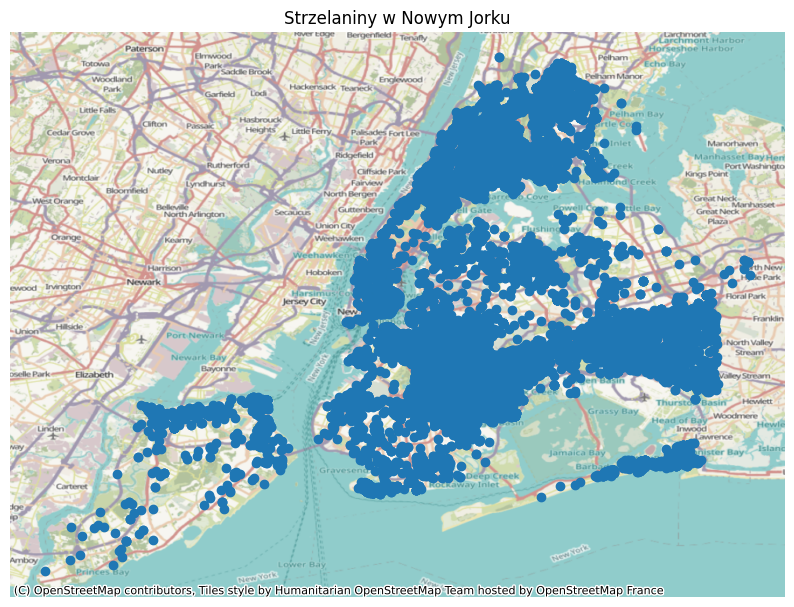

In [41]:
ax = nyc_df.plot(figsize=(10,10))
ctx.add_basemap(ax, crs=nyc_df.crs.to_string())
ax.set_axis_off()
plt.title("Strzelaniny w Nowym Jorku")
# plt.show()

## Clean data

In [44]:
nyc_df[(nyc_df['latitude'] == 0) | (nyc_df['longitude'] == 0)]

,incident_k,date_occur,time_occur,occur_time,boro,loc_of_occ,precinct,jurisdicti,loc_classf,location_d,...,perp_sex,perp_race,vic_age_gr,vic_sex,vic_race,x_coord_cd,y_coord_cd,latitude,longitude,geometry


In [45]:
nyc_df[(nyc_df['latitude'].isnull()) | (nyc_df['longitude'].isnull())]

,incident_k,date_occur,time_occur,occur_time,boro,loc_of_occ,precinct,jurisdicti,loc_classf,location_d,...,perp_sex,perp_race,vic_age_gr,vic_sex,vic_race,x_coord_cd,y_coord_cd,latitude,longitude,geometry
1406,250584475,2022-09-03,00:00:00.000,22:45:00,BROOKLYN,OUTSIDE,90.0,0.0,STREET,(null),...,(null),(null),18-24,F,WHITE HISPANIC,998002,196692,NaN,NaN,None
25597,259091227,2022-12-19,00:00:00.000,23:23:00,BROOKLYN,OUTSIDE,60.0,0.0,STREET,(null),...,M,BLACK,25-44,M,BLACK,990784,149362,NaN,NaN,None
25598,251253188,2022-09-18,00:00:00.000,03:40:00,MANHATTAN,OUTSIDE,34.0,0.0,STREET,(null),...,(null),(null),18-24,M,BLACK HISPANIC,1002173,249401,NaN,NaN,None
25832,254053457,2022-11-13,00:00:00.000,01:00:00,QUEENS,OUTSIDE,110.0,0.0,PLAYGROUND,(null),...,M,WHITE HISPANIC,25-44,M,WHITE HISPANIC,1019164,210169,NaN,NaN,None
25938,252281471,2022-10-09,00:00:00.000,19:15:00,BROOKLYN,OUTSIDE,61.0,0.0,HOUSING,MULTI DWELL - PUBLIC HOUS,...,M,WHITE HISPANIC,25-44,M,BLACK,995122,155693,NaN,NaN,None
26273,251690448,2022-09-27,00:00:00.000,23:30:00,MANHATTAN,OUTSIDE,28.0,0.0,STREET,(null),...,M,BLACK,18-24,M,BLACK,997407,233806,NaN,NaN,None
26741,251690448,2022-09-27,00:00:00.000,23:30:00,MANHATTAN,OUTSIDE,28.0,0.0,STREET,(null),...,M,BLACK,25-44,M,BLACK,997407,233806,NaN,NaN,None
26814,255042633,2022-12-03,00:00:00.000,10:21:00,MANHATTAN,OUTSIDE,33.0,0.0,STREET,(null),...,(null),(null),18-24,M,BLACK HISPANIC,1001891,245600,NaN,NaN,None
26875,250460651,2022-09-01,00:00:00.000,01:15:00,QUEENS,OUTSIDE,103.0,0.0,OTHER,(null),...,(null),(null),18-24,M,BLACK,1041717,197008,NaN,NaN,None
27205,250340401,2022-08-30,00:00:00.000,00:10:00,BROOKLYN,OUTSIDE,84.0,0.0,STREET,(null),...,(null),(null),25-44,F,BLACK,988902,192641,NaN,NaN,None


In [46]:
print("Puste wartości w kolumnie 'Longitude':", nyc_df['longitude'].isnull().sum())
print("Puste wartości w kolumnie 'Latitude':", nyc_df['latitude'].isnull().sum())
nyc_df = nyc_df.dropna(subset=['longitude', 'latitude'])

Puste wartości w kolumnie 'Longitude': 10
Puste wartości w kolumnie 'Latitude': 10


In [47]:
print("Puste wartości w kolumnie 'Longitude':", nyc_df['longitude'].isnull().sum())
print("Puste wartości w kolumnie 'Latitude':", nyc_df['latitude'].isnull().sum())

Puste wartości w kolumnie 'Longitude': 0
Puste wartości w kolumnie 'Latitude': 0


## Analysis data

In [49]:
print(f"Descriptions: {nyc_df.crs}\n"); print(f"Columns: {nyc_df.columns}\n"); print(f"Shape: {nyc_df.shape}")

Descriptions: GEOGCS["WGS84(DD)",DATUM["WGS84",SPHEROID["WGS84",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AXIS["Longitude",EAST],AXIS["Latitude",NORTH]]

Columns: Index(['incident_k', 'date_occur', 'time_occur', 'occur_time', 'boro',
       'loc_of_occ', 'precinct', 'jurisdicti', 'loc_classf', 'location_d',
       'statistica', 'perp_age_g', 'perp_sex', 'perp_race', 'vic_age_gr',
       'vic_sex', 'vic_race', 'x_coord_cd', 'y_coord_cd', 'latitude',
       'longitude', 'geometry'],
      dtype='object')

Shape: (27302, 22)


In [50]:
nyc_df.describe()

,precinct,jurisdicti,latitude,longitude
count,27302.000000,27300.000000,27302.000000,27302.000000
mean,65.636290,0.327033,40.737892,-73.909051
std,27.304504,0.737851,0.087525,0.066272
min,1.000000,0.000000,40.511586,-74.249303
25%,44.000000,0.000000,40.668481,-73.943027
50%,68.000000,0.000000,40.700318,-73.915221
75%,81.000000,0.000000,40.824067,-73.882330
max,123.000000,2.000000,40.910818,-73.702046


array([[<Axes: title={'center': 'precinct'}>,
        <Axes: title={'center': 'jurisdicti'}>],
       [<Axes: title={'center': 'latitude'}>,
        <Axes: title={'center': 'longitude'}>]], dtype=object)

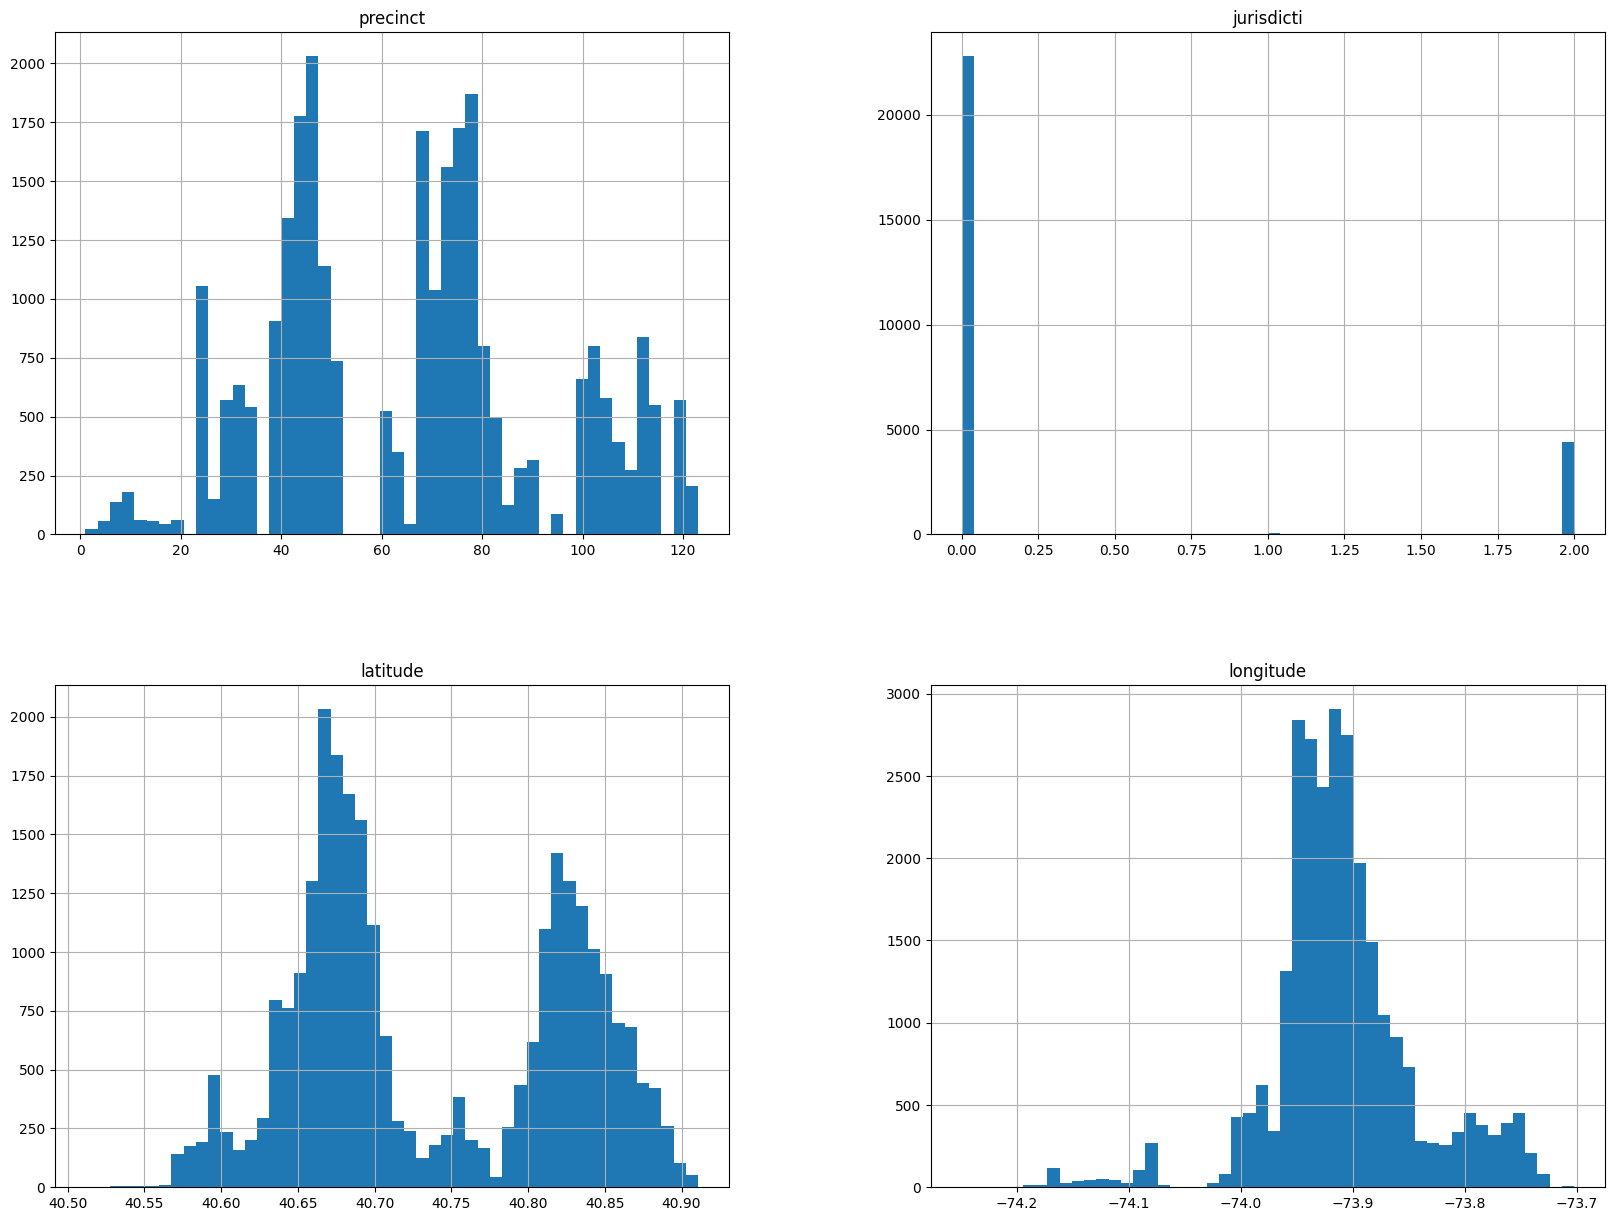

In [51]:
nyc_df.hist(bins=50,figsize=(20,15))

In [52]:
nyc_df.vic_sex.value_counts()

vic_sex
M    24678
F     2613
U       11
Name: count, dtype: int64

In [ ]:
pd.get_dummies(nyc_df['vic_sex']).head()

## DBSCAN from API

In [73]:
from sklearn.cluster import DBSCAN

In [76]:
missing_values = nyc_df[['latitude', 'longitude']].isnull().sum()
missing_values

latitude     0
longitude    0
dtype: int64

In [75]:
nyc_df = nyc_df.dropna(subset=['longitude', 'latitude'])

In [77]:
# Prepare the clean data for DBSCAN
clean_coords = nyc_df[['latitude', 'longitude']].to_numpy()

In [78]:
clean_coords

array([[ 40.66296462, -73.73083869],
       [ 40.81035186, -73.92494233],
       [ 40.74260663, -73.91549174],
       ...,
       [ 40.81020941, -73.9394955 ],
       [ 40.855644  , -73.896141  ],
       [ 40.837102  , -73.847134  ]])

In [83]:
# Reinitialize and fit the DBSCAN model with clean data
db_clean = DBSCAN(eps=0.005, min_samples=10).fit(clean_coords)

# Assign cluster labels to the clean dataframe
nyc_df['cluster'] = db_clean.labels_

# Overview of the cluster distribution in the cleaned data
clean_cluster_distribution = nyc_df['cluster'].value_counts()
clean_cluster_distribution.head()

cluster
 0    12239
 1    10741
-1      577
 3      558
 6      550
Name: count, dtype: int64

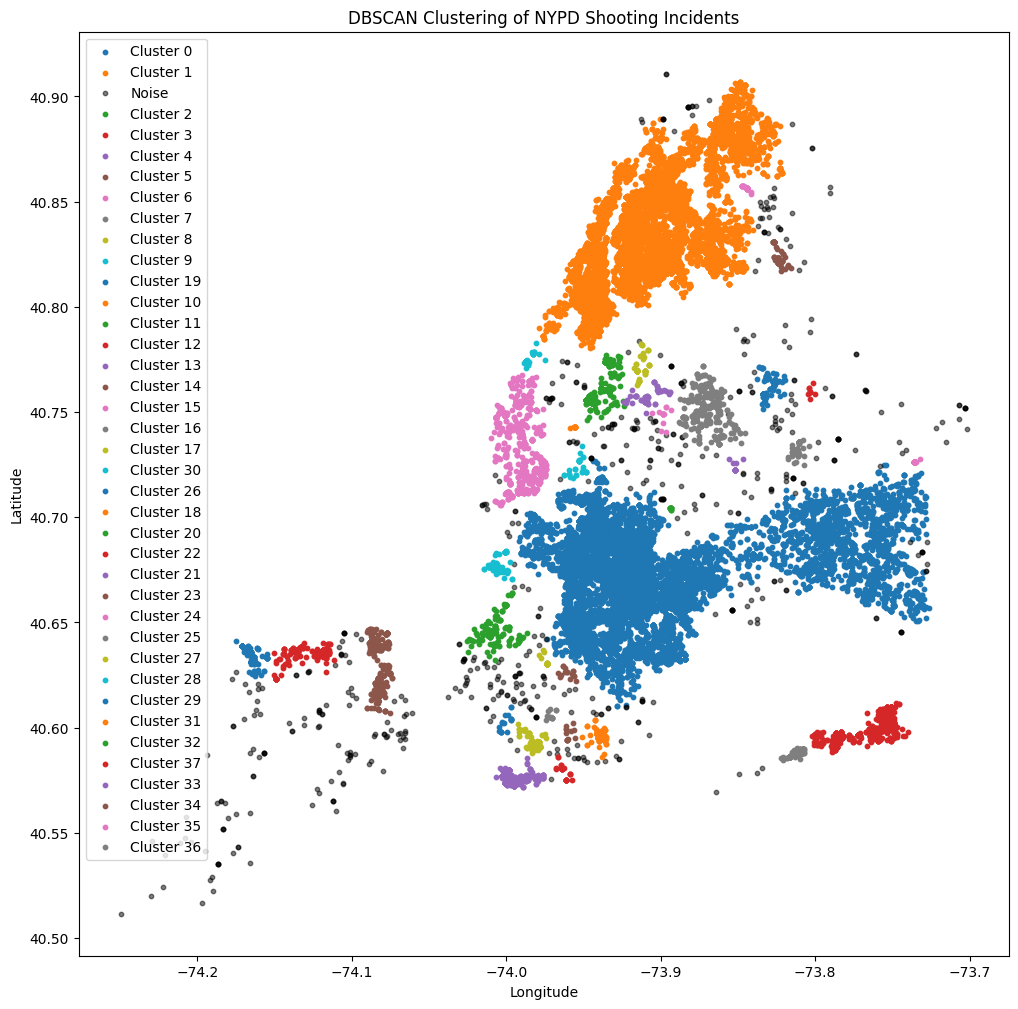

In [84]:
# Set up the plot
fig, ax = plt.subplots(1, 1, figsize=(12, 12))

# Plotting each cluster with a different color
labels = nyc_df['cluster'].unique()
for label in labels:
    cluster_data = nyc_df[nyc_df['cluster'] == label]
    if label == -1:
        # Plot noise points in black
        ax.scatter(cluster_data['longitude'], cluster_data['latitude'], c='k', label=f'Noise', s=10, alpha=0.5)
    else:
        ax.scatter(cluster_data['longitude'], cluster_data['latitude'], label=f'Cluster {label}', s=10)

# Setting up additional parameters for the plot
ax.set_title('DBSCAN Clustering of NYPD Shooting Incidents')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.legend()

# Display the plot
plt.show()

# POLICE PRECINTS
https://www.nyc.gov/site/planning/data-maps/open-data/districts-download-metadata.page <br>
Columns descriptions: https://s-media.nyc.gov/agencies/dcp/assets/files/pdf/data-tools/bytes/nypp_metadata.pdf

## Download Police precincts file locally or copy directly from link

In [66]:
if IS_DOWNLOAD_DATASETS:
    if not os.path.isfile(POL_PREC_FILENAME):
        response = requests.get(POL_PREC_URL)
        if response.status_code == 200:
            with open(POL_PREC_FILENAME, 'wb') as file:
                file.write(response.content)
            print(f'Plik {POL_PREC_FILENAME} został pomyślnie pobrany i zapisany.')
        else:
            print(f'Nie można pobrać pliku. Kod odpowiedzi HTTP: {response.status_code}')
    else:
        print(f'Plik {POL_PREC_FILENAME} już istnieje na dysku.')
    police_df = gpd.read_file(POL_PREC_FILENAME)
else:
    police_df = gpd.read_file(POL_PREC_URL)
    print(f"Dane zostały skopiowane z linku {POL_PREC_URL}")

Plik data/Police Precincts.zip już istnieje na dysku.


## Print Police Precincts locations

In [56]:
police_df.head()

,precinct,shape_area,shape_leng,geometry
0,1.0,4.728501e+07,80093.534429,"MULTIPOLYGON (((-74.04388 40.69019, -74.04351 ..."
1,5.0,1.809453e+07,18807.124911,"POLYGON ((-73.98864 40.72293, -73.98869 40.722..."
2,6.0,2.201795e+07,24875.964217,"POLYGON ((-73.99968 40.73855, -73.99684 40.737..."
3,7.0,1.836667e+07,17287.544493,"POLYGON ((-73.97346 40.71896, -73.97357 40.718..."
4,9.0,2.139539e+07,19772.510741,"POLYGON ((-73.97161 40.72672, -73.97163 40.726..."


Text(0.5, 1.0, 'Mapa obwodów policyjnych')

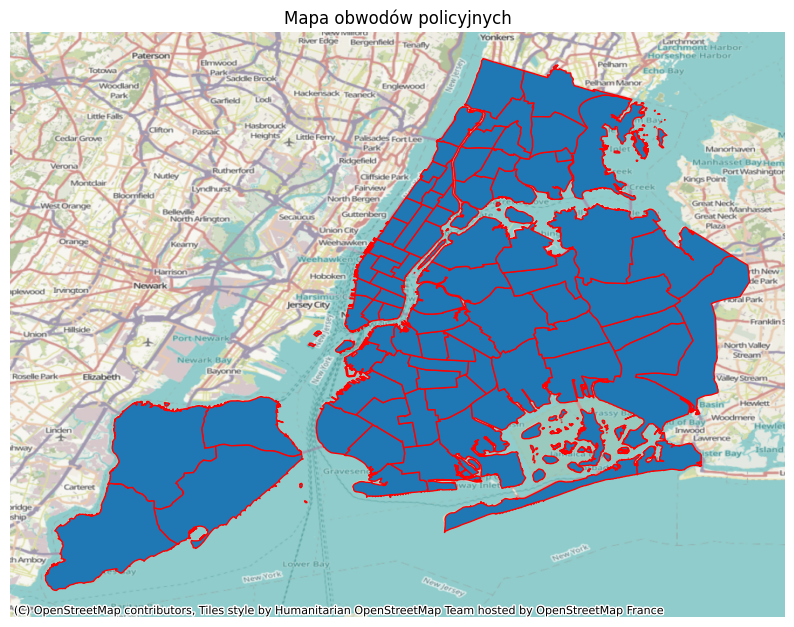

In [55]:
ax2 = police_df.plot(figsize=(10,10), edgecolor='red')
ctx.add_basemap(ax2, crs=police_df.crs.to_string())
ax2.set_axis_off()
plt.title("Mapa obwodów policyjnych")

In [57]:
police_df.shape

(77, 4)